In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from erddapy import ERDDAP
import json
import re

Pull in the processed inventory

In [2]:
ra = "cencoos"

#
# df_cruise = df[df['Station Description'] == 'Chesapeake Bay WQ Cruise Data ']
#
#df_aws = df[df['Station ID'] == 'Humboldt']
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/OMOECC_E1/OMOECC_E1.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/45186/45186.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/bgsusd2/bgsusd2.ncml'
# url = 'http://oos.soest.hawaii.edu/thredds/dodsC/hioos/nss/ns12agg'
# print(url)
# ds = xr.open_dataset(url)
# #ds = netCDF4.Dataset(url,'r')
# title = ds.title
# start_time = np.datetime_as_string(ds.time.min().values, unit='D')
# end_time = np.datetime_as_string(ds.time.max().values, unit='D')
# print('Duration: %s - %s' % (np.datetime_as_string(ds.time.min().values, unit='D'),
#                              np.datetime_as_string(ds.time.max().values, unit='D'))
#       )

# Try glos web server
# url = 'https://glbuoys.glos.us/tools/export?ftype=csv&data_type=buoy&units=eng&locs=OMOECC_E1&params=Water_Temperature_at_Surface|dissolved_oxygen_saturation|water_conductivity|ysi_turbidity&tperiod=custom&date_start=2020-01-01&date_end=2020-12-31&avg_ivld=none'
# df = erddapy.ERDDAP.to_pandas(url)

## using ERDDAP to look for stations
# check out http://data.glos.us/erddap/tabledap/allDatasets.htmlTable?datasetID%2Ctitle%2CminTime%2CmaxTime&maxTime%3E=2020-01-01&maxTime%3C=2020-12-31&orderBy(%22maxTime%22)
# that lists out all the GLOS stations with the maximum time of observations within the year 2020 (on their ERDDAP).


ra_clean = re.sub(r'[0-9]', '', ra) # remove number from RA 

df = pd.read_excel('2024/data/processed/%s.xlsx' % ra_clean.upper(), dtype=str)
df.head()

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
0,CeNCOOS,Trinidad,TDPC1,Trinidad Pier,Trinidad Shore Station,41.06,-124.15,fixed pier,2008-12-31 00:00:00,y,Cal Poly Humboldt/CeNCOOS,Yp,Cal Poly Humboldt,Academic,Cal Poly Humboldt,CeNCOOS/Cal Poly Humboldt,"sea_water_temperature(4.6m), sea_water_salinit...",Need to check variables
1,CeNCOOS,Humboldt,HBXC1,Humboldt Bay: Chevron Dock,Chevron Dock Pier Station,40.78,-124.2,fixed pier,2003,y,Cal Poly Humboldt/CeNCOOS,yp,Cal Poly Humboldt,Academic,Cal Poly Humboldt,CeNCOOS/Cal Poly Humboldt,"sea_water_temperature(2m), sea_water_salinity(...",NaN
2,CeNCOOS,Humboldt,N/A not real-time,Humboldt Bay: South Bay,Humboldt Bay South Bay Station,40.43,-124.13,fixed pier,2006-08-01 00:00:00,y,Cal Poly Humboldt/CeNCOOS,Yp,Cal Poly Humboldt,Academic,Cal Poly Humboldt,Cal Poly Humboldt,"sea_water_temperature(2m), sea_water_salinity(...",NaN
3,CeNCOOS,Tuluwat Island,N/A was off line for a long time,Tuluwat Island,Tuluwat Island,40.81,-124.15,fixed pier,2015,y,Wiyot/CeNCOOS/Cal Poly Humboldt,Yp,Wiyot,Tribal,Wiyot,CeNCOOS/Cal Poly Humboldt,"sea_water_temperature(2.4m), sea_water_salini...",NaN
4,CeNCOOS,Cal Poly Humboldt IFCB,N/A,Cal Poly Humboldt IFCB,Cal Poly Humboldt IFCB,40.79394,-124.192885,fixed pier,2022-09-01 00:00:00,o,NaN,Yp,Cal Poly Humboldt,Academic,Cal Poly Humboldt,NaN,NaN,NaN


## Check column headers

The official column headers are found in the README at https://github.com/ioos/ioos-asset-inventory/tree/main. This checks the column headers from the RA inventory against our official column headers to see if anything is missing. The result will print out what columns are missing from the RA inventory and what columns the RA added to their inventory.

In [3]:
url = 'https://github.com/ioos/ioos-asset-inventory/tree/main'

import pandas as pd

df_fields = pd.read_html(url)#

control_fields = df_fields[2]['Field'].tolist()


def diff(a, b):
  if len(set(a) - set(b)) > 0:
    print(f"Columns missing: {set(a) - set(b)}")
  if len(set(b) - set(a)) > 0:
    print(f"Columns added: {set(b) - set(a)}")
  if set(a) == set(b):
    print(f"They are the same")

diff(control_fields, df.columns.tolist())

They are the same


Make a plot of all points.

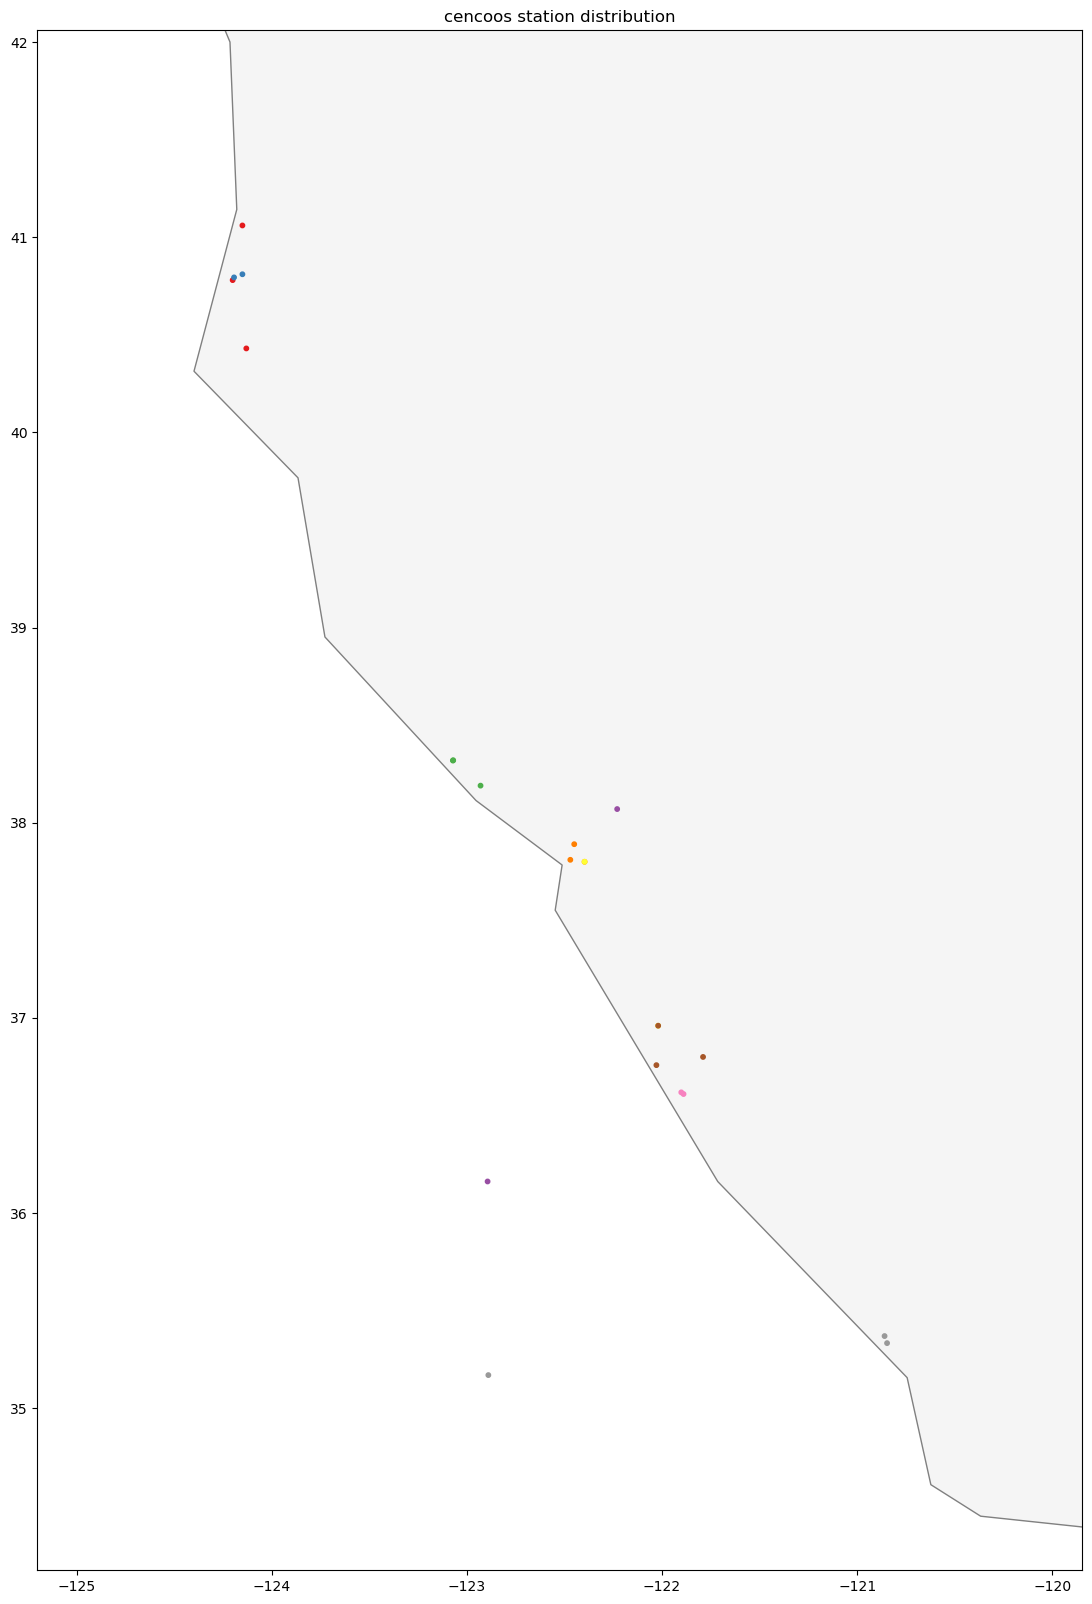

In [4]:
import geopandas
import matplotlib.pyplot as plt

#df = df.loc[df['']]

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='whitesmoke', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         #column='erddap_avail', 
         categorical=True, 
         cmap = 'Set1',
         markersize=10, 
         legend=True,
         legend_kwds={'title': "ERDDAP Available?"},
         k=2,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)

plt.title('{} station distribution'.format(ra))

plt.show()

Make an interactive map.

When you click on a point the return is the information from the inventory.

In [5]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.loc[~gdf_final['geometry'].is_empty == True].drop(columns='Variable Names').explore()#'erddap_avail',cmap = 'Set1')


Configure the ERDDAP to search

In [6]:
with open('utils/ra_erddaps.json') as f:
    urls = json.load(f)

server = urls[ra.lower()]

print(server)

e = ERDDAP(server=server, protocol="tabledap")

http://erddap.cencoos.org/erddap


Search the ERDDAP server for a single station of interest - more of a test

In [7]:
# df['Station ID'].loc[df['Station ID'].isna()] = df.loc[df['Station ID'].isna(),'Dataset ID']

# df['Station ID']

In [8]:
# df_wf = df[df['Station ID'] == 'Jug_Bay']

# # for SCCOOS need to search for 'Station Long Name' as 'Station ID' is NA for most entries
# search_for = df_wf['Station ID'].to_string()

# search_url = e.get_search_url(search_for=search_for, response="csv")

# try:
#     resp = pd.read_csv(search_url)
#     print(resp['Station ID'])
# except:
#     pass

Rip through all the datasets in the inventory and see if they exist on the RA erddap. Process checks the following order:

1. `Station ID`, then 
2. `Station Long Name`, then
3. `WMO ID or NWS/CMAN ID`

We first check if the value is `nan`. If so, we punt as that will return all datasets from the ERDDAP service.

In [9]:
not_found = []
found = dict()

exclude = ' -gliders'


if ra == 'glos':
    search_order = ['Dataset (ERDDAP) ID','Station ID', 'Station Long Name']
elif ra == 'sccoos':
    search_order = ['Station Long Name', 'WMO ID or NWS/CMAN ID', 'Station Description']
else:
    search_order = ['Station ID', 'Station Long Name', 'WMO ID or NWS/CMAN ID']

for search1 in df[search_order[0]].astype(str):

    if search1 == "nan":
        print("punting with %s = nan\n" % search_order[0])
        not_found.append(search1)
        continue
    
    try:
        print('searching \"%s\" = \"%s\"' % (search_order[0], search1))
        search_url = e.get_search_url(search_for=search1+exclude, response="csv")
        resp = pd.read_csv(search_url)
        
        print("Found \"%s\": %s" % (search1,resp['Dataset ID'].values.tolist()))
        
        for dset_id in resp['Dataset ID'].values.tolist():
            if search1.lower() in dset_id.lower():
                found[search1] = {'Dataset ID': [dset_id]}
                print("Keeping \"%s\": %s" % (search1,dset_id))
                #found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
        
    except:
        
        print('no dataset matching \"%s\"' % search1)
        search2 = df.loc[df[search_order[0]] == search1, search_order[1]].values.tolist()[0]
        
        if search2 == "nan":
                print("punting with %s = nan\n" % search_order[1])
                not_found.append(search1)
                continue
                
        try:
            
            print('searching \"%s\" = \"%s\"' % (search_order[1], search2))
            search_url = e.get_search_url(search_for=search2+exclude, response="csv")
            resp = pd.read_csv(search_url)
            print("Found \"%s\": %s" % (search2,resp['Dataset ID'].values.tolist()))
            
            found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
            
        except:

            search3 = str(df.loc[df[search_order[0]] == search1, search_order[2]].values.tolist()[0])
            
            if search3 == "nan":
                print("punting with \"%s\" = nan\n" % search_order[2])
                not_found.append(search1)
                continue
            
            try:
                print('searching \"%s\" = \"%s\"' % (search_order[2], search3))
                search_url = e.get_search_url(search_for=search3+exclude, response="csv")
                resp = pd.read_csv(search_url)
                print("Found \"%s\": %s" % (search3,resp['Dataset ID'].values.tolist()))
                
                found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
                
            except:
                print("Couldn't find:", [search1, search2, search3])
                not_found.append(search1)
        
    print("\n")

searching "Station ID" = "Trinidad"


Found "Trinidad": ['saic_thd', 'th01-trinidad-head-line', 'th02-trinidad-head-line', 'th03-trinidad-head-line', 'th04-trinidad-head-line', 'th05-trinidad-head-line', 'th06-trinidad-head-line', 'gov_usgs_nwis_11481200', 'edu_humboldt_tdp']
Keeping "Trinidad": th01-trinidad-head-line
Keeping "Trinidad": th02-trinidad-head-line
Keeping "Trinidad": th03-trinidad-head-line
Keeping "Trinidad": th04-trinidad-head-line
Keeping "Trinidad": th05-trinidad-head-line
Keeping "Trinidad": th06-trinidad-head-line


searching "Station ID" = "Humboldt"
Found "Humboldt": ['humboldt-bay-burkeolator', 'edu_ucsd_cdip_128', 'edu_ucsd_cdip_168', 'noaa_nos_co_ops_9418767', 'noaa_nos_co_ops_9418768', 'edu_humboldt_humboldt', 'edu_humboldt_tdp', 'saic_hbc', 'th06-trinidad-head-line', 'th01-trinidad-head-line', 'th02-trinidad-head-line', 'th03-trinidad-head-line', 'th04-trinidad-head-line', 'th05-trinidad-head-line', 'wiyot_tribe_indianisland', 'thoon-th02']
Keeping "Humboldt": humboldt-bay-burkeolator
Keeping "H

Print the stations that we couldn't find.

In [10]:
len(not_found)

4

In [11]:
len(found)

6

Show me the record that has NaN for the first search element.

In [12]:
df.loc[df[search_order[0]].isna()]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry


Now show me the stations, with identifiers, that we couldn't find.

In [13]:
df[df[search_order[0]].isin(not_found)]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry
4,CeNCOOS,Cal Poly Humboldt IFCB,N/A,Cal Poly Humboldt IFCB,Cal Poly Humboldt IFCB,40.79394,-124.192885,fixed pier,2022-09-01 00:00:00,o,NaN,Yp,Cal Poly Humboldt,Academic,Cal Poly Humboldt,NaN,NaN,NaN,POINT (-124.19289 40.79394)
6,CeNCOOS,IFCB163,NaN,Bodega IFCB163,Bodega IFCB163,38.3185,-123.0716,fixed intake,2022-06-01 00:00:00,y,UC Davis/CeNCOOS,Yp,UC Davis (BML),Academic,UC Davis (BML),NaN,NaN,NaN,POINT (-123.07160 38.31850)
13,CeNCOOS,IFCB San Francisco Pier 17,NaN,San Francisco Pier 17 IFCB,San Francisco Pier 17 IFCB,37.8,-122.397,fixed pier,2016-09-01 00:00:00,o,UCSC,N,UCSC,Academic,UCSC,UCSC,NaN,NaN,POINT (-122.39700 37.80000)
15,CeNCOOS,IFCB Santa Cruz,NaN,Santa Cruz Municipal Wharf IFCB,Santa Cruz Municipal Wharf IFCB,36.96,-122.02,fixed pier,2015-08-01 00:00:00,y,UCSC,N,UCSC,Academic,UCSC,UCSC,NaN,NaN,POINT (-122.02000 36.96000)


Print out all the dataset IDs for the datasets that matched our criteria.

In [14]:
found

{'Trinidad': {'Dataset ID': ['th06-trinidad-head-line']},
 'Humboldt': {'Dataset ID': ['edu_humboldt_tdp']},
 'Carquinez': {'Dataset ID': ['carquinez']},
 'Tiburon': {'Dataset ID': ['tiburon-weather-tibc1']},
 'Exploratorium': {'Dataset ID': ['exploratorium-pco2-buoy']},
 'M1': {'Dataset ID': ['nmb14-nmb14m1t']}}

Check if each found dataset has coverage for specified CY

In [15]:
valid_datasets = []

cy = '2024'
n=0
for key in found:
    
    print(f'testing {key}')
    
    dataset_id = found[key]['Dataset ID'] #+" "+found[key]['Station ID']
    
    if (len(dataset_id)>1):
        
        for dataset in dataset_id:
            n+=1
            if (n<3):
                e.dataset_id = dataset
        
                e.constraints = {
                    "time>=": "{}-01-01".format(cy)
                }
            
                e.variables = ['time']
        
                try:
                    df_data = e.to_pandas(parse_dates=True)
                    valid_datasets.extend([key])
                    
                except:

                    print(f'No data for {cy} for {key}: dataset ID {e.dataset_id}')# % (key,e.dataset_id))

                    pass

                

    else:
        
        e.dataset_id = dataset_id[0]
    
        e.constraints = {
                         "time>=": "{}-01-01".format(cy)
                        }
        
        e.variables = ['time']
        
        try:
            
            df_data = e.to_pandas(parse_dates=True)

            valid_datasets.extend([key])

        except:

            print(f'No data for {cy} for {key}: dataset ID {e.dataset_id}')# % (key,e.dataset_id))
            
            pass

            #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

            
#for valid in sorted(set(valid_datasets)):
    
#     # drop qc vars
#     cols = [c for c in df_data.columns if 'qc' not in c]
#     cols = [c for c in cols if 'QARTOD' not in c]

#     df_data = df_data[cols]

#     # set index for plotting
#     df_data = df_data.set_index(df_data['time (UTC)'])

#     # plot
#     #df_data.plot(subplots=True, title=e.dataset_id,figsize=(20,20))

#     start_time = df_data['time (UTC)'].min()
#     end_time = df_data['time (UTC)'].max()

#     print('Dataset %s' % e.dataset_id)
#     print('Duration: %s - %s' % (start_time, end_time))

no_cov_datasets = found.keys() - sorted(set(valid_datasets))

print('Datasets without coverage for {}:\n{}'.format(cy,no_cov_datasets))

testing Trinidad
No data for 2024 for Trinidad: dataset ID th06-trinidad-head-line
testing Humboldt
testing Carquinez
testing Tiburon
testing Exploratorium
testing M1
No data for 2024 for M1: dataset ID nmb14-nmb14m1t
Datasets without coverage for 2024:
{'Trinidad', 'M1'}


Show me the inventory metadata about the invalid stations:

In [16]:
bad_stations = df.loc[(df[search_order[0]].isin(no_cov_datasets)) | df[search_order[0]].isin(not_found)]

df['erddap_not_avail'] = df[search_order[0]].isin(bad_stations[search_order[0]])

df.loc[df['erddap_not_avail']]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_not_avail
0,CeNCOOS,Trinidad,TDPC1,Trinidad Pier,Trinidad Shore Station,41.06,-124.15,fixed pier,2008-12-31 00:00:00,y,Cal Poly Humboldt/CeNCOOS,Yp,Cal Poly Humboldt,Academic,Cal Poly Humboldt,CeNCOOS/Cal Poly Humboldt,"sea_water_temperature(4.6m), sea_water_salinit...",Need to check variables,POINT (-124.15000 41.06000),True
4,CeNCOOS,Cal Poly Humboldt IFCB,N/A,Cal Poly Humboldt IFCB,Cal Poly Humboldt IFCB,40.79394,-124.192885,fixed pier,2022-09-01 00:00:00,o,NaN,Yp,Cal Poly Humboldt,Academic,Cal Poly Humboldt,NaN,NaN,NaN,POINT (-124.19289 40.79394),True
6,CeNCOOS,IFCB163,NaN,Bodega IFCB163,Bodega IFCB163,38.3185,-123.0716,fixed intake,2022-06-01 00:00:00,y,UC Davis/CeNCOOS,Yp,UC Davis (BML),Academic,UC Davis (BML),NaN,NaN,NaN,POINT (-123.07160 38.31850),True
13,CeNCOOS,IFCB San Francisco Pier 17,NaN,San Francisco Pier 17 IFCB,San Francisco Pier 17 IFCB,37.8,-122.397,fixed pier,2016-09-01 00:00:00,o,UCSC,N,UCSC,Academic,UCSC,UCSC,NaN,NaN,POINT (-122.39700 37.80000),True
15,CeNCOOS,IFCB Santa Cruz,NaN,Santa Cruz Municipal Wharf IFCB,Santa Cruz Municipal Wharf IFCB,36.96,-122.02,fixed pier,2015-08-01 00:00:00,y,UCSC,N,UCSC,Academic,UCSC,UCSC,NaN,NaN,POINT (-122.02000 36.96000),True
17,CeNCOOS,M1,46092,M1,M1,36.758,-122.029,moored buoy,1991,y,MBARI,n,MBARI,nonprofit,MBARI,MBARI,"sea_water_temperature(1m,10m,20m,40m,60m,80m,...",NaN,POINT (-122.02900 36.75800),True


Invert the `erddap_not_avail` column and drop it.

In [17]:
df['erddap_avail'] = ~df['erddap_not_avail']

df.drop(columns='erddap_not_avail', inplace=True)

df

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_avail
0,CeNCOOS,Trinidad,TDPC1,Trinidad Pier,Trinidad Shore Station,41.06,-124.15,fixed pier,2008-12-31 00:00:00,y,Cal Poly Humboldt/CeNCOOS,Yp,Cal Poly Humboldt,Academic,Cal Poly Humboldt,CeNCOOS/Cal Poly Humboldt,"sea_water_temperature(4.6m), sea_water_salinit...",Need to check variables,POINT (-124.15000 41.06000),False
1,CeNCOOS,Humboldt,HBXC1,Humboldt Bay: Chevron Dock,Chevron Dock Pier Station,40.78,-124.2,fixed pier,2003,y,Cal Poly Humboldt/CeNCOOS,yp,Cal Poly Humboldt,Academic,Cal Poly Humboldt,CeNCOOS/Cal Poly Humboldt,"sea_water_temperature(2m), sea_water_salinity(...",NaN,POINT (-124.20000 40.78000),True
2,CeNCOOS,Humboldt,N/A not real-time,Humboldt Bay: South Bay,Humboldt Bay South Bay Station,40.43,-124.13,fixed pier,2006-08-01 00:00:00,y,Cal Poly Humboldt/CeNCOOS,Yp,Cal Poly Humboldt,Academic,Cal Poly Humboldt,Cal Poly Humboldt,"sea_water_temperature(2m), sea_water_salinity(...",NaN,POINT (-124.13000 40.43000),True
3,CeNCOOS,Tuluwat Island,N/A was off line for a long time,Tuluwat Island,Tuluwat Island,40.81,-124.15,fixed pier,2015,y,Wiyot/CeNCOOS/Cal Poly Humboldt,Yp,Wiyot,Tribal,Wiyot,CeNCOOS/Cal Poly Humboldt,"sea_water_temperature(2.4m), sea_water_salini...",NaN,POINT (-124.15000 40.81000),True
4,CeNCOOS,Cal Poly Humboldt IFCB,N/A,Cal Poly Humboldt IFCB,Cal Poly Humboldt IFCB,40.79394,-124.192885,fixed pier,2022-09-01 00:00:00,o,NaN,Yp,Cal Poly Humboldt,Academic,Cal Poly Humboldt,NaN,NaN,NaN,POINT (-124.19289 40.79394),False
5,CeNCOOS,Bodega,BDXC1,Bodega,Horeshoe cove BML Seawater Intake Station,38.32,-123.07,fixed intake,2003,y,UC Davis/CeNCOOS,yp,UC Davis (BML),Academic,UC Davis (BML),BML,"sea_water_temperature(2.9m), sea_water_salinit...",SAMI purchased for (not yet received),POINT (-123.07000 38.32000),True
6,CeNCOOS,IFCB163,NaN,Bodega IFCB163,Bodega IFCB163,38.3185,-123.0716,fixed intake,2022-06-01 00:00:00,y,UC Davis/CeNCOOS,Yp,UC Davis (BML),Academic,UC Davis (BML),NaN,NaN,NaN,POINT (-123.07160 38.31850),False
7,CeNCOOS,Tomales Bay,NaN,Tomales Bay,Tomales Bay Buoy,38.19,-122.93,moored buoy,2013-06-03 00:00:00,y,UC Davis/CeNCOOS,n,UC Davis (BML),Academic,UC Davis (BML),BML,"sea_water_temperature, sea_water_salinity, mas...",NaN,POINT (-122.93000 38.19000),True
8,CeNCOOS,Hog Island,NaN,Hog Island,Hog Island Hatchery,36.162,-122.8939,fixed intake,2014-05-31 00:00:00,y,UC Davis/CeNCOOS,Yp,UC Davis,Academic,UC Davis,UC Davis,"sea_water_temperature(3.03m), sea_water_salini...",NaN,POINT (-122.89390 36.16200),True
9,CeNCOOS,Carquinez,CQU1,Carquinez,Carquinez at Cal Maritime,38.07,-122.23,fixed pier,2008-02-21 00:00:00,y,SFSU/CeNCOOS,Yp,SFSU,Academic,SFSU,SFSU,"sea_water_temperature(2.7m), sea_water_salini...",Changed from YSI to SeaBird (purchased SeaBird...,POINT (-122.23000 38.07000),True


Make a plot of all points and color based on ERDDAP available or not.

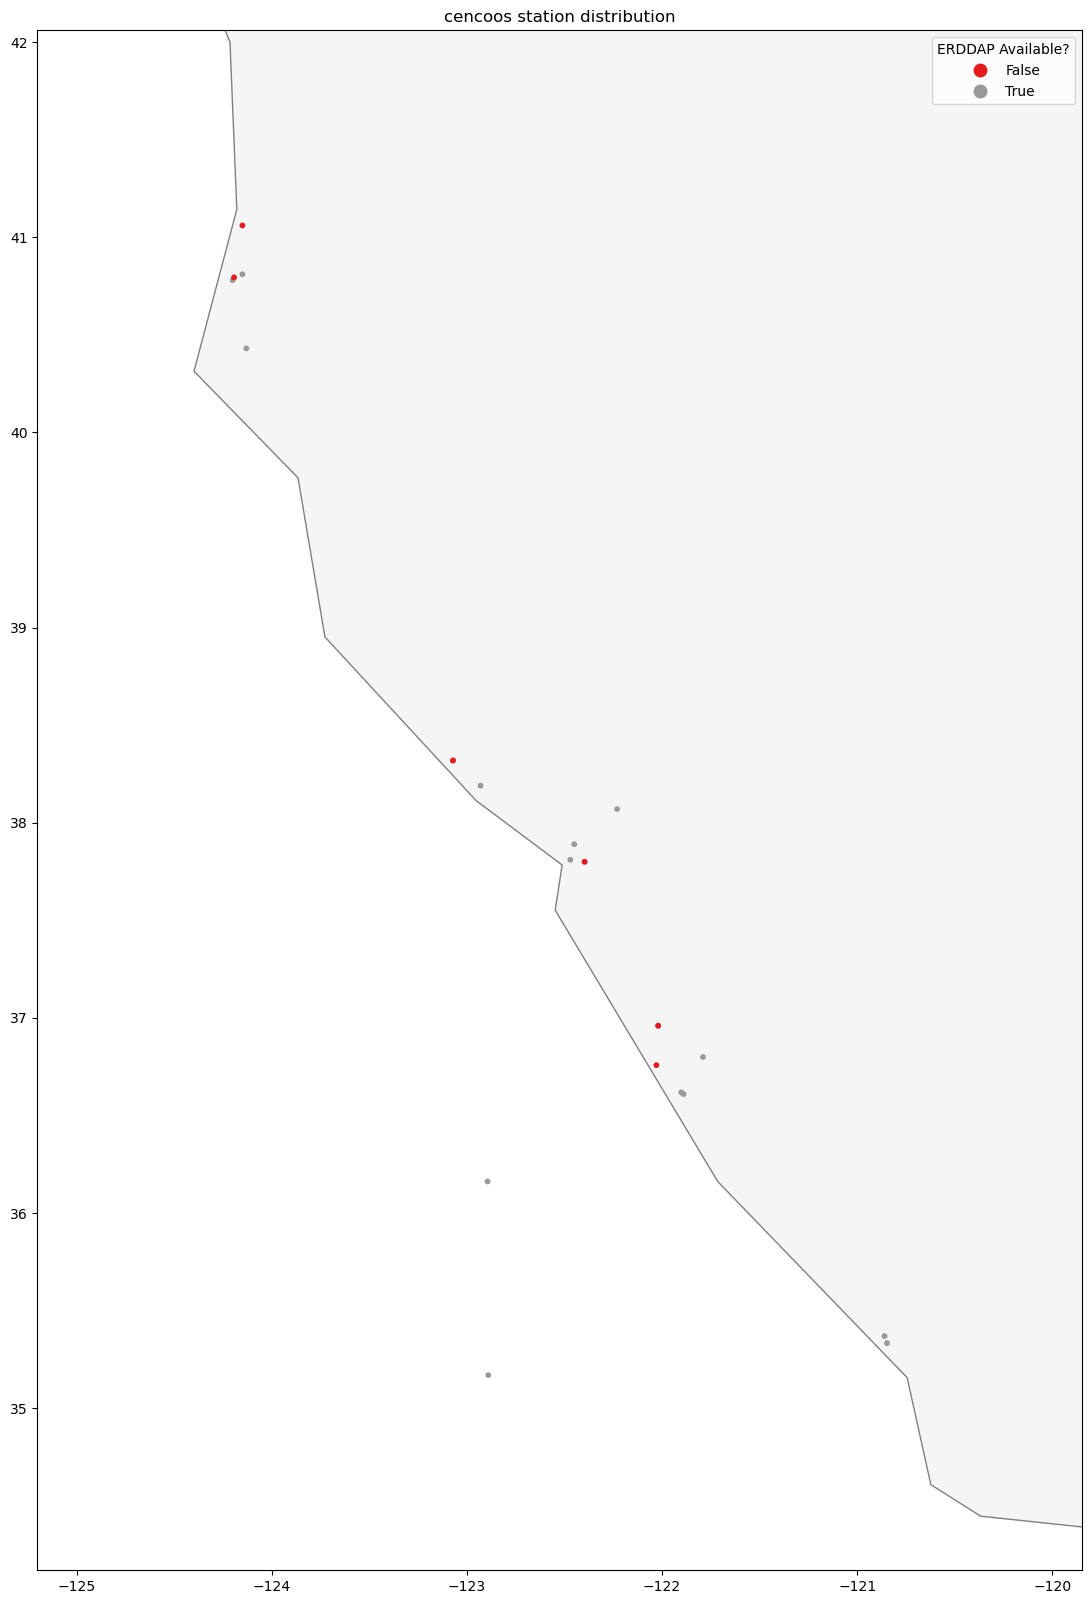

In [18]:
import geopandas
import matplotlib.pyplot as plt

#df = df.loc[df['']]

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='whitesmoke', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         column='erddap_avail', 
         categorical=True, 
         cmap = 'Set1',
         markersize=10, 
         legend=True,
         legend_kwds={'title': "ERDDAP Available?"},
         k=2,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)

plt.title('{} station distribution'.format(ra))

plt.show()

Make an interactive map.

When you click on a point the return is the information from the inventory.

In [19]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.loc[~gdf_final['geometry'].is_empty == True].drop(columns='Variable Names').explore('erddap_avail',cmap = 'Set1', style_kwds={"radius":5})


## Show me some bad coordinates

_if there are any_

In [20]:
gdf_final.loc[gdf_final['geometry'].is_empty == True]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_avail


In [21]:
# import urllib.request
# for url in gdf_final.loc[gdf_final['erddap_not_avail'],'Station Description'].str.replace('url: ',''):
#     print(url)
#     try:
#         urllib.request.urlopen(url).getcode()
#     except:
#         print("URL broken: %s" % url)
#         print(gdf_final.loc[gdf_final['Station Description'].str.contains(url,regex=False),'Station ID'])

# Show me the stations where ERDDAP doesn't exist or provide a valid response.

Reasons:
* Station not found on RA erddap
* dataset found but no data for this CY.

In [22]:
gdf_final.loc[~gdf_final['erddap_avail']]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_avail
0,CeNCOOS,Trinidad,TDPC1,Trinidad Pier,Trinidad Shore Station,41.06,-124.15,fixed pier,2008-12-31 00:00:00,y,Cal Poly Humboldt/CeNCOOS,Yp,Cal Poly Humboldt,Academic,Cal Poly Humboldt,CeNCOOS/Cal Poly Humboldt,"sea_water_temperature(4.6m), sea_water_salinit...",Need to check variables,POINT (-124.15000 41.06000),False
4,CeNCOOS,Cal Poly Humboldt IFCB,N/A,Cal Poly Humboldt IFCB,Cal Poly Humboldt IFCB,40.79394,-124.192885,fixed pier,2022-09-01 00:00:00,o,NaN,Yp,Cal Poly Humboldt,Academic,Cal Poly Humboldt,NaN,NaN,NaN,POINT (-124.19289 40.79394),False
6,CeNCOOS,IFCB163,NaN,Bodega IFCB163,Bodega IFCB163,38.3185,-123.0716,fixed intake,2022-06-01 00:00:00,y,UC Davis/CeNCOOS,Yp,UC Davis (BML),Academic,UC Davis (BML),NaN,NaN,NaN,POINT (-123.07160 38.31850),False
13,CeNCOOS,IFCB San Francisco Pier 17,NaN,San Francisco Pier 17 IFCB,San Francisco Pier 17 IFCB,37.8,-122.397,fixed pier,2016-09-01 00:00:00,o,UCSC,N,UCSC,Academic,UCSC,UCSC,NaN,NaN,POINT (-122.39700 37.80000),False
15,CeNCOOS,IFCB Santa Cruz,NaN,Santa Cruz Municipal Wharf IFCB,Santa Cruz Municipal Wharf IFCB,36.96,-122.02,fixed pier,2015-08-01 00:00:00,y,UCSC,N,UCSC,Academic,UCSC,UCSC,NaN,NaN,POINT (-122.02000 36.96000),False
17,CeNCOOS,M1,46092,M1,M1,36.758,-122.029,moored buoy,1991,y,MBARI,n,MBARI,nonprofit,MBARI,MBARI,"sea_water_temperature(1m,10m,20m,40m,60m,80m,...",NaN,POINT (-122.02900 36.75800),False


# Do some checking against the IOOS catalog

only for datasets that we couldn't find in ERDDAP (per above)

In [23]:
from ckanapi import RemoteCKAN
import xarray as xr

problem_datasets = []

ua = 'ckanapiioos/1.0 (+https://ioos.us/)'

#ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua, get_only=True)
ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua)
ioos_catalog

gdf_ckan = gdf_final.loc[~gdf_final['erddap_avail']]

for station in gdf_ckan['Station ID'].dropna():

    RA = gdf_ckan.loc[gdf_ckan['Station ID']==station,'RA'].tolist()[0]
    
    print('Station "{}" + RA "{}"'.format(station.lower(), RA.lower()))
    
    # build RA tag query
    fq = '+organization:{}'.format(RA.lower())

    # build free text query
    q = "\""+station.lower()+"\""+" -glider"

    query = ioos_catalog.address + '/dataset/?' + 'q=' + q + '&organization=' + RA.lower()
    
    print('Query: {}'.format(query.replace(" ","%20")))

    datasets = ioos_catalog.action.package_search(q=q, fq=fq)

    

    if datasets['count'] > 0:
        print('\tfound {} dataset(s):'.format(datasets['count']))
        
        for dataset in datasets['results']:
            print('\t',dataset['title'])
            
            
            if dataset['resources']:
                print('\t',dataset['resources'][0]['url'])

                start_date = next(item for item in dataset["extras"] if item["key"] == "temporal-extent-begin")['value']
                end_date = next(item for item in dataset["extras"] if item["key"] == "temporal-extent-end")['value']

                print('\t','Coverage Meta:\n\t\t', start_date,' - ',end_date,'\n')

                if 'thredds' in dataset['resources'][0]['url']:
                    ds = xr.open_dataset(dataset['resources'][0]['url'])

                    time_max = ds.time.max().values

                    time_min = ds.time.min().values


                    print('\tCoverage Data:\n\t\t', time_min,' - ',time_max, '\n')

                    if pd.to_datetime(end_date) < pd.to_datetime(time_max, utc=True):
                        test_date = pd.to_datetime(time_max, utc=True)

                else:
                    test_date = pd.to_datetime(end_date, utc=True)

                if test_date > pd.to_datetime('{}-01-01'.format(cy), utc=True):
                    print('\t{} is valid.'.format(station))
                    break
                else:
                    print('\t{} is not valid.'.format(station))

                    problem_datasets.append(station)
            
            else:
                print('\t{} missing additional metadata'.format(station))
                problem_datasets.append(station)
    else:
        print("\tNo datasets found!")
        problem_datasets.append(station)

Station "trinidad" + RA "cencoos"
Query: https://data.ioos.us/dataset/?q="trinidad"%20-glider&organization=cencoos
	found 22 dataset(s):
	 TH06, Trinidad Head Line
	 https://erddap.cencoos.org/erddap/tabledap/th06-trinidad-head-line
	 Coverage Meta:
		 2007-02-13T13:52:40Z  -  2014-07-16T07:27:33Z 

	Trinidad is not valid.
	 TH01, Trinidad Head Line
	 https://erddap.cencoos.org/erddap/tabledap/th01-trinidad-head-line
	 Coverage Meta:
		 2006-11-01T09:29:03Z  -  2024-05-25T02:45:12Z 

	Trinidad is valid.
Station "cal poly humboldt ifcb" + RA "cencoos"
Query: https://data.ioos.us/dataset/?q="cal%20poly%20humboldt%20ifcb"%20-glider&organization=cencoos
	No datasets found!
Station "ifcb163" + RA "cencoos"
Query: https://data.ioos.us/dataset/?q="ifcb163"%20-glider&organization=cencoos
	No datasets found!
Station "ifcb san francisco pier 17" + RA "cencoos"
Query: https://data.ioos.us/dataset/?q="ifcb%20san%20francisco%20pier%2017"%20-glider&organization=cencoos
	No datasets found!
Station "i

Check the datasets that didn't have coverage in ERDDAP or through IOOS catalog and see if they are **Currently Operational?**

In [24]:
gdf_ckan.loc[gdf_ckan['Station ID'].isin(problem_datasets)]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_avail
0,CeNCOOS,Trinidad,TDPC1,Trinidad Pier,Trinidad Shore Station,41.06,-124.15,fixed pier,2008-12-31 00:00:00,y,Cal Poly Humboldt/CeNCOOS,Yp,Cal Poly Humboldt,Academic,Cal Poly Humboldt,CeNCOOS/Cal Poly Humboldt,"sea_water_temperature(4.6m), sea_water_salinit...",Need to check variables,POINT (-124.15000 41.06000),False
4,CeNCOOS,Cal Poly Humboldt IFCB,N/A,Cal Poly Humboldt IFCB,Cal Poly Humboldt IFCB,40.79394,-124.192885,fixed pier,2022-09-01 00:00:00,o,NaN,Yp,Cal Poly Humboldt,Academic,Cal Poly Humboldt,NaN,NaN,NaN,POINT (-124.19289 40.79394),False
6,CeNCOOS,IFCB163,NaN,Bodega IFCB163,Bodega IFCB163,38.3185,-123.0716,fixed intake,2022-06-01 00:00:00,y,UC Davis/CeNCOOS,Yp,UC Davis (BML),Academic,UC Davis (BML),NaN,NaN,NaN,POINT (-123.07160 38.31850),False
13,CeNCOOS,IFCB San Francisco Pier 17,NaN,San Francisco Pier 17 IFCB,San Francisco Pier 17 IFCB,37.8,-122.397,fixed pier,2016-09-01 00:00:00,o,UCSC,N,UCSC,Academic,UCSC,UCSC,NaN,NaN,POINT (-122.39700 37.80000),False
15,CeNCOOS,IFCB Santa Cruz,NaN,Santa Cruz Municipal Wharf IFCB,Santa Cruz Municipal Wharf IFCB,36.96,-122.02,fixed pier,2015-08-01 00:00:00,y,UCSC,N,UCSC,Academic,UCSC,UCSC,NaN,NaN,POINT (-122.02000 36.96000),False
17,CeNCOOS,M1,46092,M1,M1,36.758,-122.029,moored buoy,1991,y,MBARI,n,MBARI,nonprofit,MBARI,MBARI,"sea_water_temperature(1m,10m,20m,40m,60m,80m,...",NaN,POINT (-122.02900 36.75800),False


Print out the available metadata from the IOOS Catalog for the last dataset.

In [25]:
dataset

{'author': None,
 'author_email': None,
 'creator_user_id': '0ea3933c-4674-41dd-a17d-bfbc8c99bd75',
 'id': '909cc4d7-06f3-4db5-8da4-a540deba9e0e',
 'isopen': False,
 'license_id': None,
 'license_title': None,
 'maintainer': None,
 'maintainer_email': None,
 'metadata_created': '2025-01-09T14:04:43.620639',
 'metadata_modified': '2025-01-09T14:04:43.620654',
 'name': 'm1-meteorological-data5',
 'notes': 'On going moored observations in Monterey Bay California',
 'num_resources': 1,
 'num_tags': 15,
 'organization': {'id': '091f805a-7ab6-4d1c-8b06-1214dd5c99c6',
  'name': 'cencoos',
  'title': 'CeNCOOS',
  'type': 'organization',
  'description': 'The Central and Northern California Ocean Observing System (CeNCOOS) is one of eleven regional associations within the Integrated Ocean Observing System (IOOS) around the nation dedicated to the support of science in the service of marine ecosystem health and resource sustainability.',
  'image_url': 'https://s3.amazonaws.com/oceansmap/ioos/lo

In [26]:
# GLOS special case as they provide ERDDAP ID

# for dataset in gdf_final.loc[(~gdf_final['erddap_avail'] & ~gdf_final['Dataset (ERDDAP) ID'].isna()),'Dataset (ERDDAP) ID'].tolist():
#     print(dataset)
#     e.dataset_id = dataset
    
#     e.constraints = {
#                  "time>=": "{}-01-01".format(cy)
#             }
        
#     e.variables = ['time']
    
#     try:
        
#         df_data = e.to_pandas(parse_dates=True)
        
#         string = '\tDate range: {} - {}'.format(df_data.min()[0],df_data.max()[0])
        
#         print(string)
        
#         if pd.to_datetime(df_data.max()[0], utc=True) > pd.to_datetime('{}-01-01'.format(cy), utc=True):
            
#             datasetid = gdf_final.loc[gdf_final['Dataset (ERDDAP) ID']==dataset,'Station ID'].tolist()[0]
            
#             problem_datasets.remove(datasetid)
        
#     except:
#         print('\tNo valid data')

In [27]:
#gdf_ckan.loc[gdf_ckan['Station ID'].isin(problem_datasets)]